In [116]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, confusion_matrix, plot_confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, fbeta_score, roc_curve, roc_auc_score, plot_roc_curve


In [2]:
df = pd.read_csv('UAH-DRIVESET-classification.csv', index_col=0)
df.head()

,acceleration_score,braking_score,turning_score,weaving_score,drifting_score,speeding_score,follow_score,road_type,class_normal,temp_F,humidity_pct,wind_speed_mph,wind_gust_mph,condition,day_night,speed_mph,class_normal_bool
0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,SECONDARY,NORMAL,72,35,2,0,Fair,Night,38.955226,0
1,100.0,100.0,100.0,100.0,100.0,100.0,100.0,SECONDARY,NORMAL,72,35,2,0,Fair,Night,40.099995,0
2,100.0,100.0,100.0,100.0,100.0,100.0,100.0,SECONDARY,NORMAL,72,35,2,0,Fair,Night,40.018755,0
3,100.0,100.0,100.0,100.0,100.0,100.0,100.0,SECONDARY,NORMAL,72,35,2,0,Fair,Night,38.811020,0
4,100.0,100.0,100.0,100.0,100.0,100.0,100.0,SECONDARY,NORMAL,72,35,2,0,Fair,Night,37.524521,0


In [3]:
df['road_type_dummy'] = pd.get_dummies(df['road_type'], drop_first=True)


In [6]:
df['night_dummy'] = pd.get_dummies(df['day_night'], drop_first=True)
df.head()


,acceleration_score,braking_score,turning_score,weaving_score,drifting_score,speeding_score,follow_score,road_type,class_normal,temp_F,humidity_pct,wind_speed_mph,wind_gust_mph,condition,day_night,speed_mph,class_normal_bool,road_type_dummy,night_dummy
0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,SECONDARY,NORMAL,72,35,2,0,Fair,Night,38.955226,0,1,1
1,100.0,100.0,100.0,100.0,100.0,100.0,100.0,SECONDARY,NORMAL,72,35,2,0,Fair,Night,40.099995,0,1,1
2,100.0,100.0,100.0,100.0,100.0,100.0,100.0,SECONDARY,NORMAL,72,35,2,0,Fair,Night,40.018755,0,1,1
3,100.0,100.0,100.0,100.0,100.0,100.0,100.0,SECONDARY,NORMAL,72,35,2,0,Fair,Night,38.811020,0,1,1
4,100.0,100.0,100.0,100.0,100.0,100.0,100.0,SECONDARY,NORMAL,72,35,2,0,Fair,Night,37.524521,0,1,1


# Sub-sample the data for base models, select features

In [15]:
df_sub = df.sample(n=15000, random_state=42)


In [16]:
X = df_sub[['acceleration_score', 'braking_score', 'speeding_score']]
y = df_sub['class_normal_bool']


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


In [18]:
X_train.shape, y_train.shape

((9000, 3), (9000,))

In [19]:
fbeta_scorer = make_scorer(fbeta_score, beta=2)

# KNN

In [26]:
k_range = list(range(3, 151, 2))
weight_options = ['uniform', 'distance']

param_grid = dict(n_neighbors=k_range, weights=weight_options)

knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv=10, scoring=fbeta_scorer, n_jobs=-1)

grid.fit(X_train, y_train)

df_cv = pd.DataFrame(grid.cv_results_)


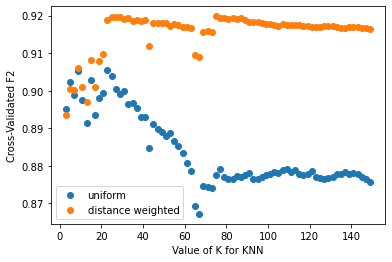

In [27]:
plt.scatter(df_cv[df_cv.param_weights == 'uniform'].param_n_neighbors, df_cv[df_cv.param_weights == 'uniform'].mean_test_score, label='uniform')
plt.scatter(df_cv[df_cv.param_weights == 'distance'].param_n_neighbors, df_cv[df_cv.param_weights == 'distance'].mean_test_score, label='distance weighted')

plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated F2')

plt.legend();


In [28]:
print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)


Best params:  {'n_neighbors': 75, 'weights': 'distance'}
Best estimator:  KNeighborsClassifier(n_neighbors=75, weights='distance')
Best score:  0.9198228779308819


# Logit

Cross-val logit

In [29]:
std_scale = StandardScaler()

X_train_scaled = std_scale.fit_transform(X_train)
X_val_scaled = std_scale.transform(X_val)
X_test_scaled = std_scale.transform(X_test)


In [33]:
C_range = list(np.logspace(-5, 3, 200))

param_grid = dict(C=C_range)

lr = LogisticRegression()
grid = GridSearchCV(lr, param_grid, cv=10, scoring=fbeta_scorer, n_jobs=-1)

grid.fit(X_train_scaled, y_train)

df_cv = pd.DataFrame(grid.cv_results_)


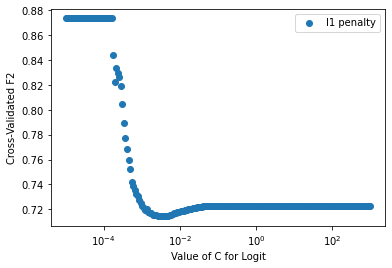

In [34]:
plt.scatter(df_cv.param_C, df_cv.mean_test_score, label='l1 penalty')

plt.xlabel('Value of C for Logit')
plt.ylabel('Cross-Validated F2')

plt.xscale('log')
plt.legend();


In [35]:
print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)


Best params:  {'C': 1e-05}
Best estimator:  LogisticRegression(C=1e-05)
Best score:  0.8735946459635333


# Decision Tree

In [42]:
max_depth_range = list(range(1,21))
criterion_options = ['entropy', 'gini']
min_samples_split_range = list(range(2,11))
min_samples_leaf_range = list(range(1,6))

param_grid = dict(max_depth=max_depth_range, criterion=criterion_options,
                  min_samples_split=min_samples_split_range, min_samples_leaf=min_samples_leaf_range)

decisiontree = DecisionTreeClassifier()
grid = GridSearchCV(decisiontree, param_grid, cv=10, scoring=fbeta_scorer, n_jobs=-1)

grid.fit(X_train, y_train)

df_cv = pd.DataFrame(grid.cv_results_)


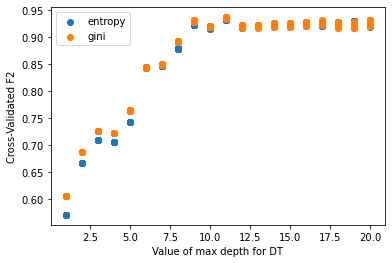

In [43]:
plt.scatter(df_cv[df_cv.param_criterion == 'entropy'].param_max_depth, df_cv[df_cv.param_criterion == 'entropy'].mean_test_score, label='entropy')
plt.scatter(df_cv[df_cv.param_criterion == 'gini'].param_max_depth, df_cv[df_cv.param_criterion == 'gini'].mean_test_score, label='gini')

plt.xlabel('Value of max depth for DT')
plt.ylabel('Cross-Validated F2')

plt.legend();


In [44]:
print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)


Best params:  {'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best estimator:  DecisionTreeClassifier(max_depth=11, min_samples_split=10)
Best score:  0.9371571919384406


# Random Forest

In [48]:
max_features_options = ['auto', 'sqrt', 'log2']
max_depth_range = list(range(5,16))
criterion_options = ['entropy', 'gini']

param_grid = dict(#n_estimators=n_estimators_range, 
                  max_features=max_features_options,
                  max_depth=max_depth_range, criterion=criterion_options)

randomforest = RandomForestClassifier(n_estimators=250)
grid = GridSearchCV(randomforest, param_grid, cv=10, scoring=fbeta_scorer, n_jobs=-1)

grid.fit(X_train, y_train)

df_cv = pd.DataFrame(grid.cv_results_)


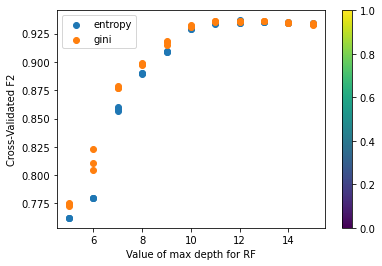

In [49]:
plt.scatter(df_cv[df_cv.param_criterion == 'entropy'].param_max_depth, df_cv[df_cv.param_criterion == 'entropy'].mean_test_score, label='entropy')
plt.scatter(df_cv[df_cv.param_criterion == 'gini'].param_max_depth, df_cv[df_cv.param_criterion == 'gini'].mean_test_score, label='gini')

plt.xlabel('Value of max depth for RF')
plt.ylabel('Cross-Validated F2')

plt.colorbar()
plt.legend();


In [50]:
print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)


Best params:  {'criterion': 'entropy', 'max_depth': 12, 'max_features': 'sqrt'}
Best estimator:  RandomForestClassifier(criterion='entropy', max_depth=12, max_features='sqrt',
                       n_estimators=250)
Best score:  0.9368353813943671


**Notes:**

- Used 3 features: acceleration, braking, speeding
- Logistic Regression (F2 score < 0.9) does not perform as well as the other models (all have F2 scores > 0.9)
    - Likely non-linear decision boundary required for classification
    - Models that can have non-linear decision boundaries (e.g., decision tree/ensemble models) will perform better
- Drop Logistic Regression from further consideration

# Add more features

In [51]:
df_sub.columns

Index(['acceleration_score', 'braking_score', 'turning_score', 'weaving_score',
       'drifting_score', 'speeding_score', 'follow_score', 'road_type',
       'class_normal', 'temp_F', 'humidity_pct', 'wind_speed_mph',
       'wind_gust_mph', 'condition', 'day_night', 'speed_mph',
       'class_normal_bool', 'road_type_dummy', 'night_dummy'],
      dtype='object')

In [52]:
X = df_sub[['acceleration_score', 'braking_score', 'turning_score', 'weaving_score',
       'drifting_score', 'speeding_score', 'follow_score', 'speed_mph', 'road_type_dummy', 'night_dummy']]
y = df_sub['class_normal_bool']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


# KNN (with more features)

In [75]:
k_range = list(range(3, 151, 2))
weight_options = ['uniform', 'distance']

param_grid = dict(n_neighbors=k_range, weights=weight_options)

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, param_grid, cv=10, scoring=fbeta_scorer, n_jobs=-1)

knn_grid.fit(X_train, y_train)

df_cv_knn = pd.DataFrame(knn_grid.cv_results_)


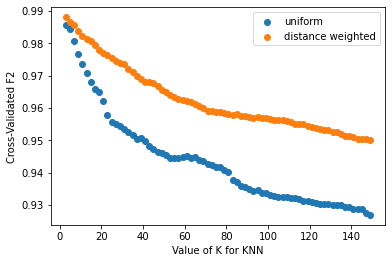

In [76]:
plt.scatter(df_cv_knn[df_cv_knn.param_weights == 'uniform'].param_n_neighbors, df_cv_knn[df_cv_knn.param_weights == 'uniform'].mean_test_score, label='uniform')
plt.scatter(df_cv_knn[df_cv_knn.param_weights == 'distance'].param_n_neighbors, df_cv_knn[df_cv_knn.param_weights == 'distance'].mean_test_score, label='distance weighted')

plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated F2')

plt.legend();


In [77]:
print("Best params: ", knn_grid.best_params_)
print("Best estimator: ", knn_grid.best_estimator_)
print("Best score: ", knn_grid.best_score_)


Best params:  {'n_neighbors': 3, 'weights': 'distance'}
Best estimator:  KNeighborsClassifier(n_neighbors=3, weights='distance')
Best score:  0.988043606849398


In [78]:
knn = KNeighborsClassifier(n_neighbors=knn_grid.best_params_['n_neighbors'], weights='distance')
knn.fit(X_train, y_train)

y_knn_pred = knn.predict(X_val)
y_knn_pred_prob = knn.predict_proba(X_val)[:, 1]

print(f'Accuracy:\t {accuracy_score(y_val, y_knn_pred):.4f}')
print(f'Precision:\t {precision_score(y_val, y_knn_pred):.4f}')
print(f'Recall:\t\t {recall_score(y_val, y_knn_pred):.4f}')
print(f'F1:\t\t {f1_score(y_val, y_knn_pred):.4f}')
print(f'Fbeta (beta=2):\t {fbeta_score(y_val, y_knn_pred, beta=2):.4f}')
print(f'AUC:\t\t {roc_auc_score(y_val, y_knn_pred):.4f}')


Accuracy:	 0.9860
Precision:	 0.9931
Recall:		 0.9829
F1:		 0.9879
Fbeta (beta=2):	 0.9849
AUC:		 0.9866


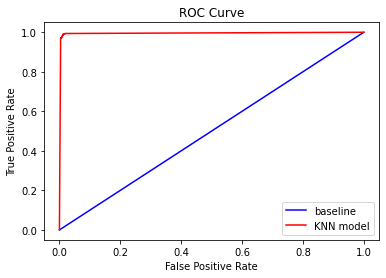

In [79]:
base_fpr, base_tpr, _ = roc_curve(y_val, [1 for _ in range(len(y_val))])
model_fpr, model_tpr, _ = roc_curve(y_val, y_knn_pred_prob)

plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'KNN model')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC Curve')

plt.legend();


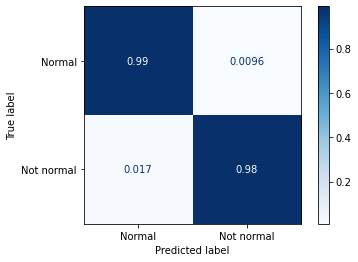

In [100]:
plot_confusion_matrix(knn, X_val, y_val,
                      display_labels=['Normal', 'Not normal'],
                      cmap=plt.cm.Blues,
                      normalize='true')


# Decision Tree (with more features)

In [67]:
max_depth_range = list(range(5,21))
criterion_options = ['entropy', 'gini']
min_samples_split_range = list(range(2,11))
min_samples_leaf_range = list(range(1,6))

param_grid = dict(max_depth=max_depth_range, criterion=criterion_options,
                  min_samples_split=min_samples_split_range, min_samples_leaf=min_samples_leaf_range)

decisiontree = DecisionTreeClassifier()
dt_grid = GridSearchCV(decisiontree, param_grid, cv=10, scoring=fbeta_scorer, n_jobs=-1)

dt_grid.fit(X_train, y_train)

df_cv_dt = pd.DataFrame(dt_grid.cv_results_)


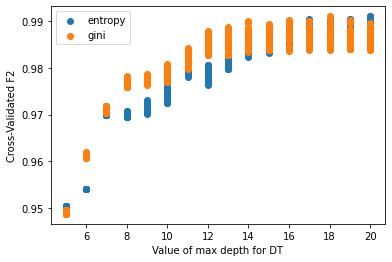

In [68]:
plt.scatter(df_cv_dt[df_cv_dt.param_criterion == 'entropy'].param_max_depth, df_cv_dt[df_cv_dt.param_criterion == 'entropy'].mean_test_score, label='entropy')
plt.scatter(df_cv_dt[df_cv_dt.param_criterion == 'gini'].param_max_depth, df_cv_dt[df_cv_dt.param_criterion == 'gini'].mean_test_score, label='gini')

plt.xlabel('Value of max depth for DT')
plt.ylabel('Cross-Validated F2')

plt.legend();


In [69]:
print("Best params: ", dt_grid.best_params_)
print("Best estimator: ", dt_grid.best_estimator_)
print("Best score: ", dt_grid.best_score_)


Best params:  {'criterion': 'gini', 'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best estimator:  DecisionTreeClassifier(max_depth=18)
Best score:  0.9911152745558341


In [70]:
dt = DecisionTreeClassifier(criterion=dt_grid.best_params_['criterion'], max_depth=dt_grid.best_params_['max_depth'], min_samples_leaf=dt_grid.best_params_['min_samples_leaf'], min_samples_split=dt_grid.best_params_['min_samples_split'])
dt.fit(X_train, y_train)

y_dt_pred = dt.predict(X_val)
y_dt_pred_prob = dt.predict_proba(X_val)[:, 1]


print(f'Accuracy:\t {accuracy_score(y_val, y_dt_pred):.4f}')
print(f'Precision:\t {precision_score(y_val, y_dt_pred):.4f}')
print(f'Recall:\t\t {recall_score(y_val, y_dt_pred):.4f}')
print(f'F1:\t\t {f1_score(y_val, y_dt_pred):.4f}')
print(f'Fbeta (beta=2):\t {fbeta_score(y_val, y_dt_pred, beta=2):.4f}')
print(f'AUC:\t\t {roc_auc_score(y_val, y_dt_pred):.4f}')


Accuracy:	 0.9880
Precision:	 0.9892
Recall:		 0.9903
F1:		 0.9897
Fbeta (beta=2):	 0.9901
AUC:		 0.9875


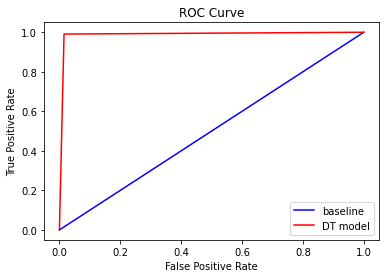

In [84]:
base_fpr, base_tpr, _ = roc_curve(y_val, [1 for _ in range(len(y_val))])
model_fpr, model_tpr, _ = roc_curve(y_val, y_dt_pred_prob)

plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'DT model')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC Curve')

plt.legend();


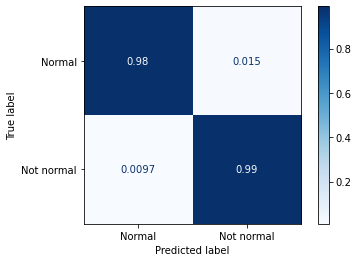

In [101]:
plot_confusion_matrix(dt, X_val, y_val,
                      display_labels=['Normal', 'Not normal'],
                      cmap=plt.cm.Blues,
                      normalize='true')


# Random Forest (with more features)

In [ ]:
n_estimators_range = [int(x) for x in np.linspace(200,2000,10)]
max_features_options = ['auto', 'sqrt', 'log2']
max_depth_range = [int(x) for x in np.linspace(10,110,11)]
max_depth_range.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4, 10]
criterion_options = ['entropy', 'gini']
bootstrap = [True, False]

param_grid = dict(max_features=max_features_options,
                  max_depth=max_depth_range, criterion=criterion_options)

randomforest = RandomForestClassifier(n_estimators=250)
rf_grid = GridSearchCV(randomforest, param_grid, cv=10, scoring=fbeta_scorer, n_jobs=-1)

rf_grid.fit(X_train, y_train)

df_cv_rf = pd.DataFrame(rf_grid.cv_results_)


In [ ]:
plt.scatter(df_cv_rf[df_cv_rf.param_criterion == 'entropy'].param_max_depth, df_cv_rf[df_cv_rf.param_criterion == 'entropy'].mean_test_score, label='entropy')
plt.scatter(df_cv_rf[df_cv_rf.param_criterion == 'gini'].param_max_depth, df_cv_rf[df_cv_rf.param_criterion == 'gini'].mean_test_score, label='gini')
plt.xlabel('Value of max depth for RF')
plt.ylabel('Cross-Validated F2')

plt.yscale('log')
plt.colorbar()
plt.legend();


In [ ]:
print("Best params: ", rf_grid.best_params_)
print("Best estimator: ", rf_grid.best_estimator_)
print("Best score: ", rf_grid.best_score_)


In [ ]:
rf = RandomForestClassifier(n_estimators=250, criterion=rf_grid.best_params_['criterion'], max_depth=rf_grid.best_params_['max_depth'], max_features=rf_grid.best_params_['max_features'])
rf.fit(X_train, y_train)

y_rf_pred = rf.predict(X_val)
y_rf_pred_prob = rf.predict_proba(X_val)[:, 1]

print(f'Accuracy:\t {accuracy_score(y_val, y_rf_pred):.4f}')
print(f'Precision:\t {precision_score(y_val, y_rf_pred):.4f}')
print(f'Recall:\t\t {recall_score(y_val, y_rf_pred):.4f}')
print(f'F1:\t\t {f1_score(y_val, y_rf_pred):.4f}')
print(f'Fbeta (beta=2):\t {fbeta_score(y_val, y_rf_pred, beta=2):.4f}')
print(f'AUC:\t\t {roc_auc_score(y_val, y_rf_pred):.4f}')


In [ ]:
base_fpr, base_tpr, _ = roc_curve(y_val, [1 for _ in range(len(y_val))])
model_fpr, model_tpr, _ = roc_curve(y_val, y_rf_pred_prob)

plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'DT model')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC Curve')

plt.legend();


In [ ]:
plot_confusion_matrix(rf, X_val, y_val,
                      display_labels=['Normal', 'Not normal'],
                      cmap=plt.cm.Blues,
                      normalize='true')


In [ ]:
labels = ['KNN', 'DT', 'RF']
y_preds = [y_knn_pred, y_dt_pred, y_rf_pred]
for i,probs in enumerate([y_knn_pred_prob, y_dt_pred_prob, y_rf_pred_prob]):
    base_fpr, base_tpr, _ = roc_curve(y_val, [1 for _ in range(len(y_val))])
    model_fpr, model_tpr, _ = roc_curve(y_val, probs)

    plt.plot(model_fpr, model_tpr, label = f'{labels[i]} (AUC: {roc_auc_score(y_val, y_preds[i]):.4f}, F2: {fbeta_score(y_val, y_preds[i], beta=2):.4f})')

#plt.plot(base_fpr, base_tpr, 'k', label = 'baseline')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)

plt.title('ROC Curves', fontsize=14)

plt.xlim(-0.01,0.15)
plt.ylim(0.85,1.01)

plt.legend(fontsize=11)

plt.savefig('roc_curves_base.png', dpi=300);


**Notes:**

- RF performs slightly better than DT and KNN models on the validation set
- Will also test an XGBoost model on these features

### Checking feature importance using Logistic Regression to see if a few features are very strong predictors

Feature: 0, Score: -0.01952
Feature: 1, Score: -0.02352
Feature: 2, Score: -0.01884
Feature: 3, Score: -0.04391
Feature: 4, Score: -0.03111
Feature: 5, Score: -0.04992
Feature: 6, Score: -0.02939
Feature: 7, Score: 0.00797
Feature: 8, Score: -0.00138
Feature: 9, Score: -0.00068


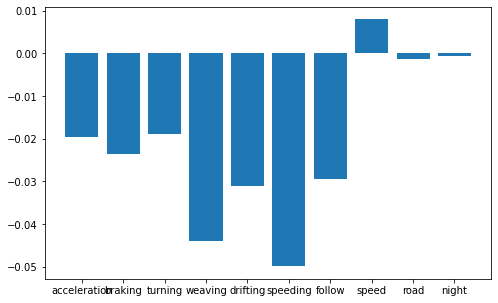

In [109]:
std_scale = StandardScaler()

X_train_scaled = std_scale.fit_transform(X_train)
X_val_scaled = std_scale.transform(X_val)
X_test_scaled = std_scale.transform(X_test)

lr = LogisticRegression(C=0.00001, max_iter=1000)
lr.fit(X_train, y_train)

importance = lr.coef_[0]
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

plt.figure(figsize=(8,5))

cols = [x.split('_')[0] for x in X_train.columns]

plt.bar(cols, importance);


# XGBoost (with more features)

In [128]:
import xgboost as xgb


In [186]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000, #arbitrary large number
                        max_depth=4,
                        objective='binary:logistic',  # Other options: https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters
                        learning_rate=.1, 
                        subsample=1,
                        min_child_weight=1,
                        colsample_bytree=.8
                       )

eval_set=[(X_train,y_train),(X_val,y_val)] #tracking train/validation error as we go
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc',
                    early_stopping_rounds=20,
                    verbose=False #gives output log as below
                   )


/Users/Hannah/anaconda/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [187]:
print(f'Fbeta (beta=2):\t {fbeta_score(y_val, gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit), beta=2):.4f}')


Fbeta (beta=2):	 0.9927


/Users/Hannah/anaconda/envs/metis/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/Hannah/anaconda/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Notes:
- Out of the box, XGBoost already out-performs Random Forest
- However, tuning XGBoost is time consuming, and Random Forest may also perform better with more tuning
- Choosing Randfom Forest classifier as final model

# Final Random Forest model tuning

In [ ]:
n_estimators_range = [int(x) for x in np.linspace(200,1000,9)]
max_features_options = ['auto', 'sqrt', 'log2']
max_depth_range = [int(x) for x in np.linspace(10,100,10)]
max_depth_range.append(None)
min_samples_split_range = [2, 5, 10]
min_samples_leaf_range = [1, 2, 4, 10]
criterion_options = ['entropy', 'gini']

param_grid = dict(n_estimators=n_estimators_range, max_features=max_features_options,
                  max_depth=max_depth_range, min_samples_split=min_samples_split_range,
                  min_samples_leaf=min_samples_leaf_range, criterion=criterion_options)

print(param_grid)
rf = RandomForestClassifier(bootstrap=True)
#rf_grid = GridSearchCV(rf, param_grid, cv=10, scoring=fbeta_scorer, n_jobs=-1)
rf_grid = RandomizedSearchCV(rf, param_grid, n_iter=100, cv=3, scoring=fbeta_scorer, n_jobs=-1)

rf_grid.fit(X_train, y_train)

df_cv_rf = pd.DataFrame(rf_grid.cv_results_)